In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch
import h5py


In [ ]:
mat_path = r'E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat'

class_map = {
    'BF': 'BF',
    'GF': 'GF',
    'TF': 'TF',   # Will use BFI data
    'N': 'NI'     # Will use NI data
}
channel_to_use = 0  # Use only channel 0


In [ ]:
ae_data = {}

with h5py.File(mat_path, 'r') as mat_file:
    ae_all = mat_file['AE_ALL']

    for cls, mapped in class_map.items():
        print(f"Loading {cls} from {mapped}...")
        ref = ae_all[mapped][channel_to_use][0]
        dataset = mat_file[ref]
        signal = np.array(dataset)  # shape: (1000000, 40)
        ae_data[cls] = signal
        print(f"{cls}: Loaded shape = {signal.shape}")


In [ ]:
def segment_signal(signal, frame_size=10000, step_size=10000):
    num_samples, num_channels = signal.shape
    segments = []

    for start in range(0, num_samples - frame_size + 1, step_size):
        end = start + frame_size
        segments.append(signal[start:end, :])

    return np.array(segments)  # shape: (num_frames, frame_size, channels)


In [ ]:
segmented_data = {}

for cls, signal in ae_data.items():
    frames = segment_signal(signal, frame_size=10000, step_size=10000)
    segmented_data[cls] = frames
    print(f"{cls}: {frames.shape[0]} frames segmented.")


In [ ]:
import pywt

def denoise_frame_wavelet(frame, wavelet='db4', level=3):
    denoised = np.zeros_like(frame)
    
    for ch in range(frame.shape[1]):
        coeffs = pywt.wavedec(frame[:, ch], wavelet, level=level)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(frame)))
        coeffs_thresh = [coeffs[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
        denoised[:, ch] = pywt.waverec(coeffs_thresh, wavelet)[:frame.shape[0]]
    
    return denoised


In [ ]:
denoised_data = {}

for cls, frames in segmented_data.items():
    denoised = np.array([denoise_frame_wavelet(frame) for frame in frames])
    denoised_data[cls] = denoised
    print(f"{cls}: {denoised.shape[0]} denoised frames.")


In [ ]:
def compute_frame_energy(frame):
    return np.sum(frame**2)

def select_burst_frames(frames, threshold_ratio=0.5):
    energies = np.array([compute_frame_energy(f) for f in frames])
    threshold = np.percentile(energies, 100 * (1 - threshold_ratio))
    selected = frames[energies >= threshold]
    return selected


In [ ]:
burst_selected_data = {}

for cls, frames in denoised_data.items():
    selected = select_burst_frames(frames, threshold_ratio=0.5)
    burst_selected_data[cls] = selected
    print(f"{cls}: Selected {len(selected)} burst frames.")


In [ ]:
def extract_features_from_signal(signal):
    mean_val = np.mean(signal)
    std_val = np.std(signal)
    rms_val = np.sqrt(np.mean(signal**2))
    peak_val = np.max(np.abs(signal))
    skewness = skew(signal)
    kurt = kurtosis(signal)
    crest_factor = peak_val / rms_val if rms_val != 0 else 0

    freqs, psd = welch(signal, fs=1e6, nperseg=1024)
    spectral_energy = np.sum(psd)
    spectral_centroid = np.sum(freqs * psd) / np.sum(psd)

    ent = entropy(np.abs(signal))
    mad = np.median(np.abs(signal - np.median(signal)))
    iqr = np.percentile(signal, 75) - np.percentile(signal, 25)

    return [
        mean_val, std_val, rms_val, peak_val,
        skewness, kurt, crest_factor,
        spectral_energy, spectral_centroid,
        ent, mad, iqr
    ]


In [ ]:
all_signal_features = []
all_signal_labels = []

for cls, frames in burst_selected_data.items():
    for frame in frames:  # shape: (10000, 40)
        for ch in range(frame.shape[1]):  # 40 signals
            signal = frame[:, ch]
            features = extract_features_from_signal(signal)
            all_signal_features.append(features)
            all_signal_labels.append(cls)


In [ ]:
signal_df = pd.DataFrame(all_signal_features)
signal_df['Label'] = all_signal_labels

print("✅ Signal-level feature extraction complete.")
print("🧾 Final shape:", signal_df.shape)
signal_df.head()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
X = signal_df.drop('Label', axis=1).values
y = signal_df['Label'].values


In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
clf_svm = SVC(probability=True, kernel='rbf', C=10)
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)


In [ ]:
ensemble = VotingClassifier(
    estimators=[
        ('SVM', clf_svm),
        ('RF', clf_rf),
        ('MLP', clf_mlp)
    ],
    voting='soft'
)


In [ ]:
ensemble.fit(X_train, y_train)


In [ ]:
y_pred = ensemble.predict(X_test)

print("✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.manifold import TSNE

# Reduce features to 2D for t-SNE (on the full dataset for visualization)
X_scaled_full = scaler.fit_transform(X)  # Normalize again for entire dataset
X_2d = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_scaled_full)

# Plot t-SNE
plt.figure(figsize=(8, 6))
for label in np.unique(y_encoded):
    idx = y_encoded == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label_encoder.inverse_transform([label])[0], alpha=0.7)

plt.title('t-SNE Visualization of Signal-Level Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()


Loading .mat file using h5py...
Loading class: N
N loaded. Shape: (1000000, 40)
Loading class: BF
BF loaded. Shape: (1000000, 40)
Loading class: GF
GF loaded. Shape: (1000000, 40)
Loading class: TF
TF loaded. Shape: (1000000, 40)

Signal Statistics:
  Class      Mean       Std       Min       Max       RMS  Peak-to-Peak  \
0     N  0.001180  0.120765 -0.756864  1.131398  0.120771      1.888263   
1    BF  0.001298  0.096944 -1.006843  1.001720  0.096952      2.008563   
2    GF  0.000670  0.054622 -0.763332  1.104557  0.054626      1.867889   
3    TF  0.000916  0.120239 -0.810870  1.198340  0.120242      2.009210   

   Samples  Channels  
0  1000000        40  
1  1000000        40  
2  1000000        40  
3  1000000        40  


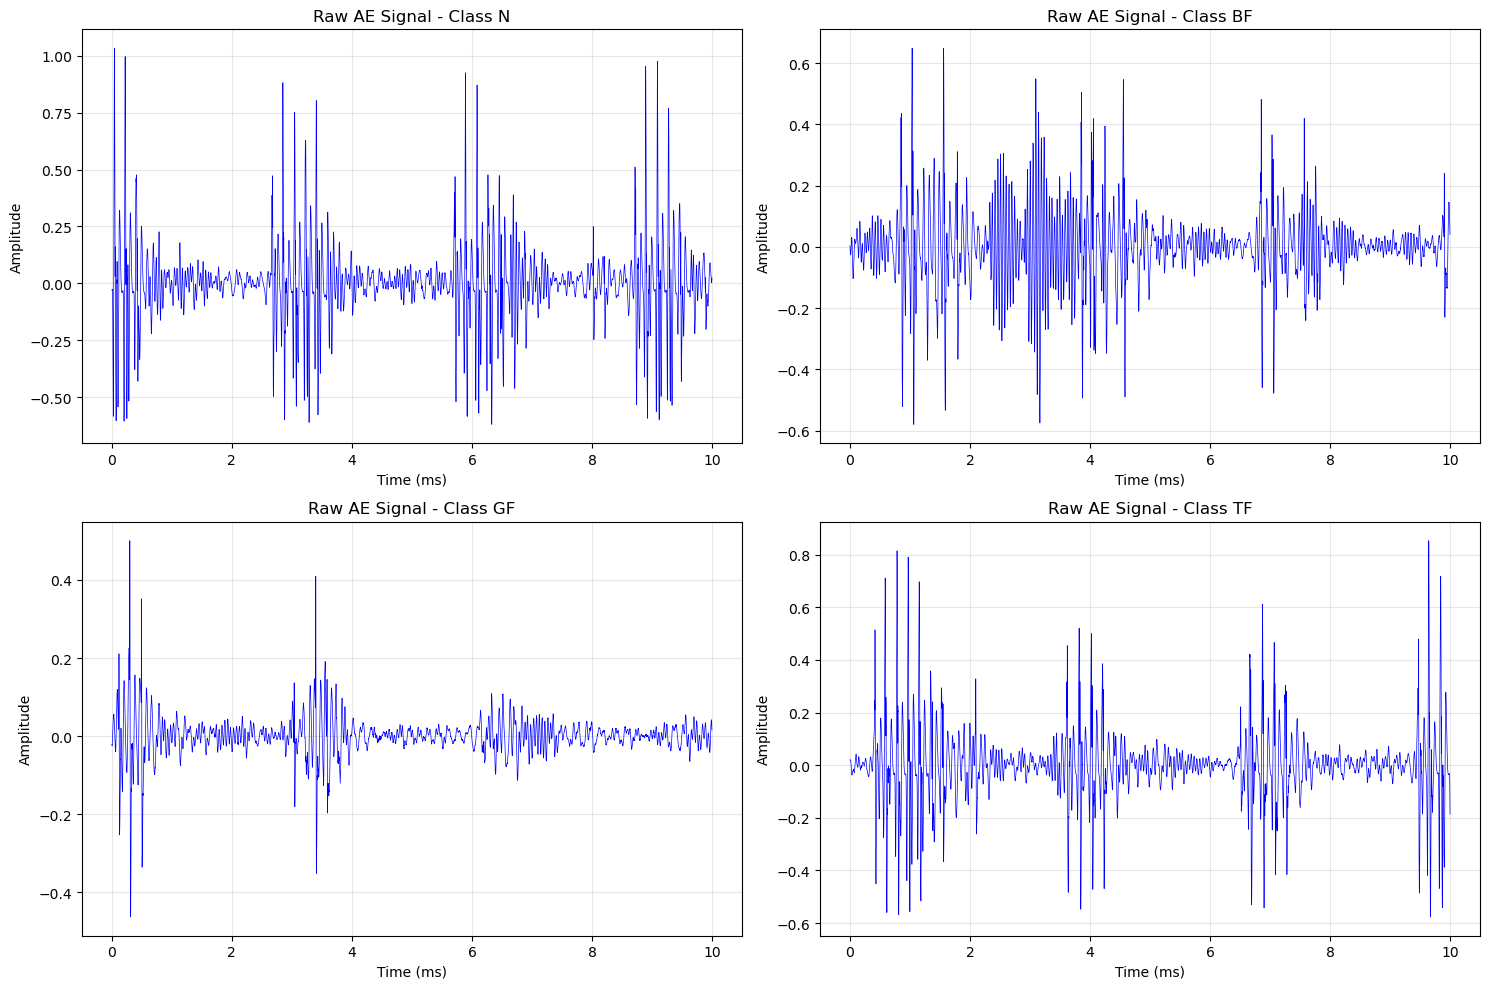


Step 1 completed: AE signals loaded and visualized!
Ready to proceed to Step 2: Burst-Informed Signal Processing


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Step 1: Input AE Signals
class AESignalProcessor:
    def __init__(self, mat_path, sampling_rate=1000000):  # 1 MHz sampling rate
        self.mat_path = mat_path
        self.sampling_rate = sampling_rate
        self.data = {}
        self.selected_classes = ['N', 'BF', 'GF', 'TF']  # Selected classes
        
    def load_data(self):
        """Load .mat file (v7.3 HDF5) and extract selected classes using h5py"""
        print("Loading .mat file using h5py...")
        with h5py.File(self.mat_path, 'r') as mat_file:
            ae_all = mat_file['AE_ALL']

            for class_name in self.selected_classes:
                if class_name in ae_all:
                    print(f"Loading class: {class_name}")
                    class_refs = ae_all[class_name]

                    # Reference to actual signal dataset
                    ref = class_refs[0, 0]  # Cell reference
                    signals = mat_file[ref]  # Dereference to actual dataset

                    class_data = signals[()]  # Keep shape (1000000, 40)
                    self.data[class_name] = class_data
                    print(f"{class_name} loaded. Shape: {class_data.shape}")
                else:
                    print(f"Warning: {class_name} not found in AE_ALL")

        return self.data
    
    def visualize_raw_signals(self, duration=0.01):  # Show 10ms of data
        """Visualize raw AE signals for each class"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        samples = int(duration * self.sampling_rate)  # Number of samples to display
        time = np.arange(samples) / self.sampling_rate * 1000  # Convert to milliseconds
        
        for i, class_name in enumerate(self.selected_classes):
            if class_name in self.data:
                # Take first channel, first 'samples' points
                signal_data = self.data[class_name][:samples, 0]
                
                axes[i].plot(time, signal_data, 'b-', linewidth=0.5)
                axes[i].set_title(f'Raw AE Signal - Class {class_name}')
                axes[i].set_xlabel('Time (ms)')
                axes[i].set_ylabel('Amplitude')
                axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def signal_statistics(self):
        """Calculate basic statistics for each class"""
        stats_data = []
        
        for class_name in self.selected_classes:
            if class_name in self.data:
                signal_data = self.data[class_name]
                
                # Calculate statistics for first channel
                channel_data = signal_data[:, 0]
                
                stats = {
                    'Class': class_name,
                    'Mean': np.mean(channel_data),
                    'Std': np.std(channel_data),
                    'Min': np.min(channel_data),
                    'Max': np.max(channel_data),
                    'RMS': np.sqrt(np.mean(channel_data**2)),
                    'Peak-to-Peak': np.max(channel_data) - np.min(channel_data),
                    'Samples': len(channel_data),
                    'Channels': signal_data.shape[1]
                }
                stats_data.append(stats)
        
        stats_df = pd.DataFrame(stats_data)
        print("\nSignal Statistics:")
        print(stats_df)
        return stats_df

# Initialize and run Step 1
def main():
    # Path to .mat file
    mat_path = r'E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\mat files data\AE_ALL.mat'
    processor = AESignalProcessor(mat_path)
    
    # Load the data
    data = processor.load_data()
    
    # Display signal statistics
    stats = processor.signal_statistics()
    
    # Visualize raw signals
    processor.visualize_raw_signals()
    
    return processor

# Run Step 1
if __name__ == "__main__":
    processor = main()
    print("\nStep 1 completed: AE signals loaded and visualized!")
    print("Ready to proceed to Step 2: Burst-Informed Signal Processing")


Running Step 2: Burst-Informed Signal Processing...
Starting Burst-Informed Signal Processing...
Processing class N...
  Created 1952 frames
  Selected 585 frames based on burst activity
Processing class BF...
  Created 1952 frames
  Selected 585 frames based on burst activity
Processing class GF...
  Created 1952 frames
  Selected 585 frames based on burst activity
Processing class TF...
  Created 1952 frames
  Selected 585 frames based on burst activity
Burst-Informed Signal Processing completed!


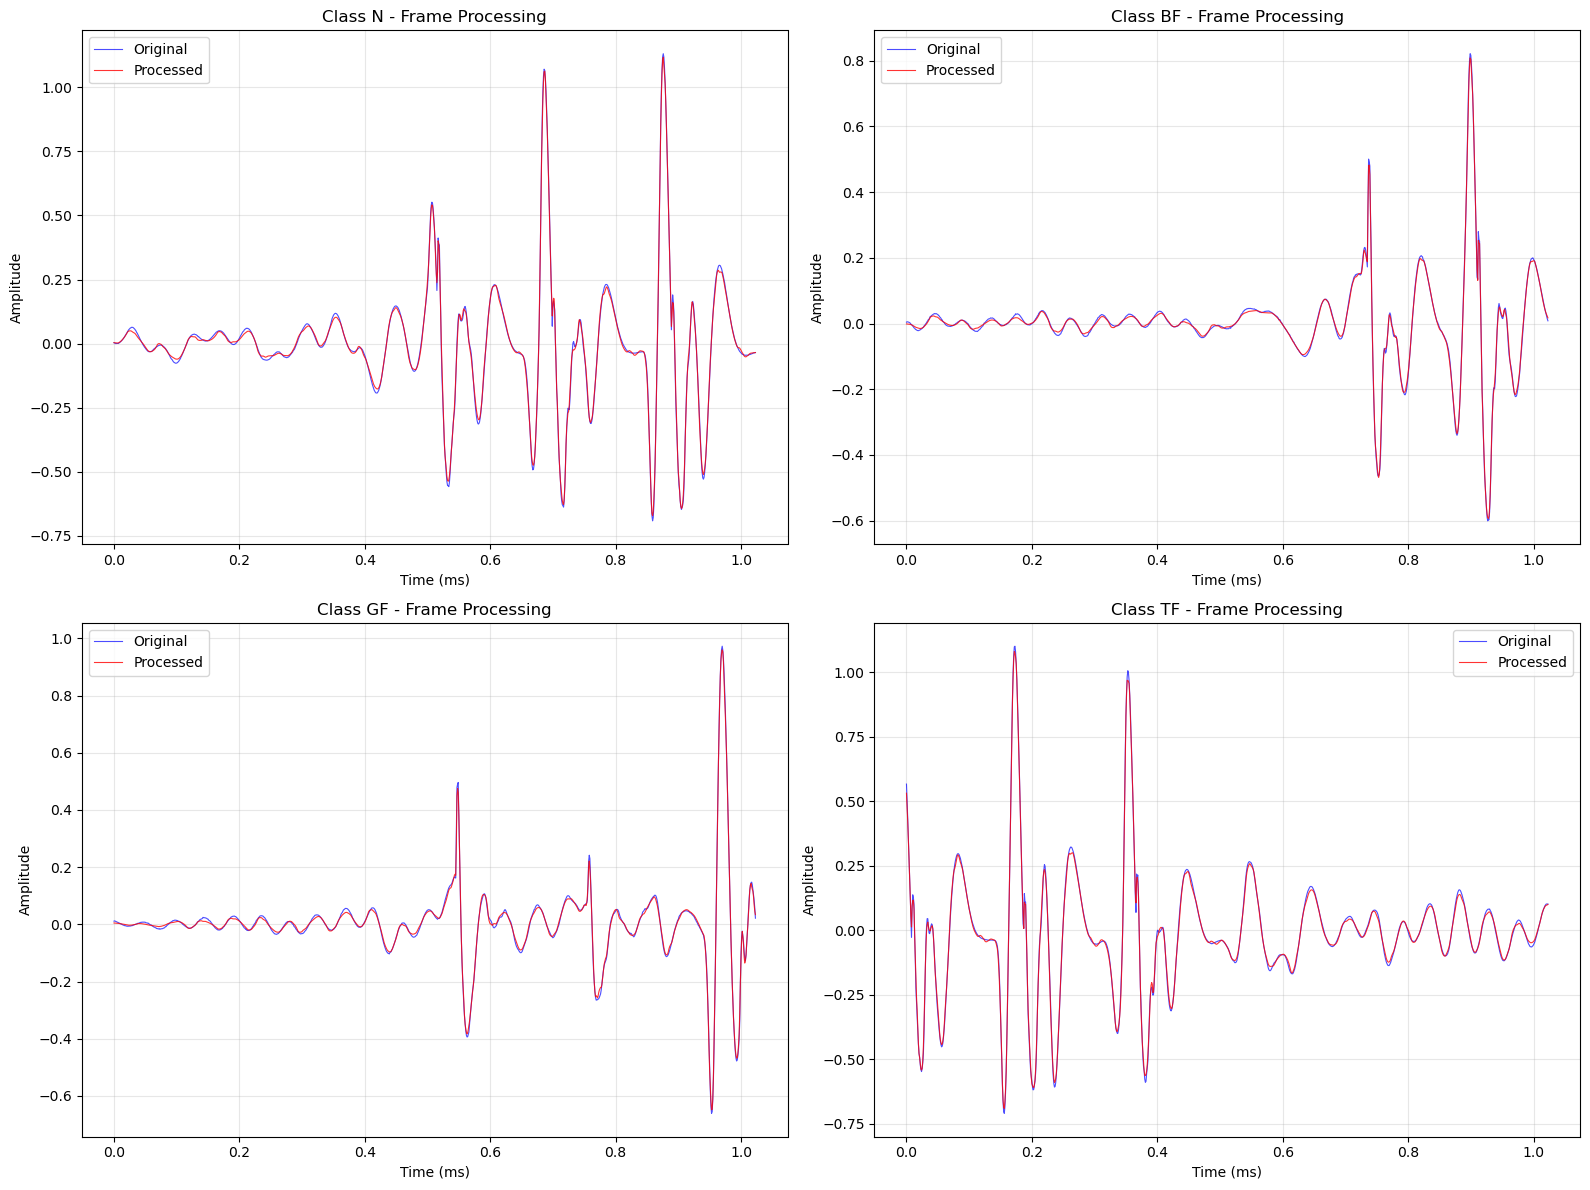

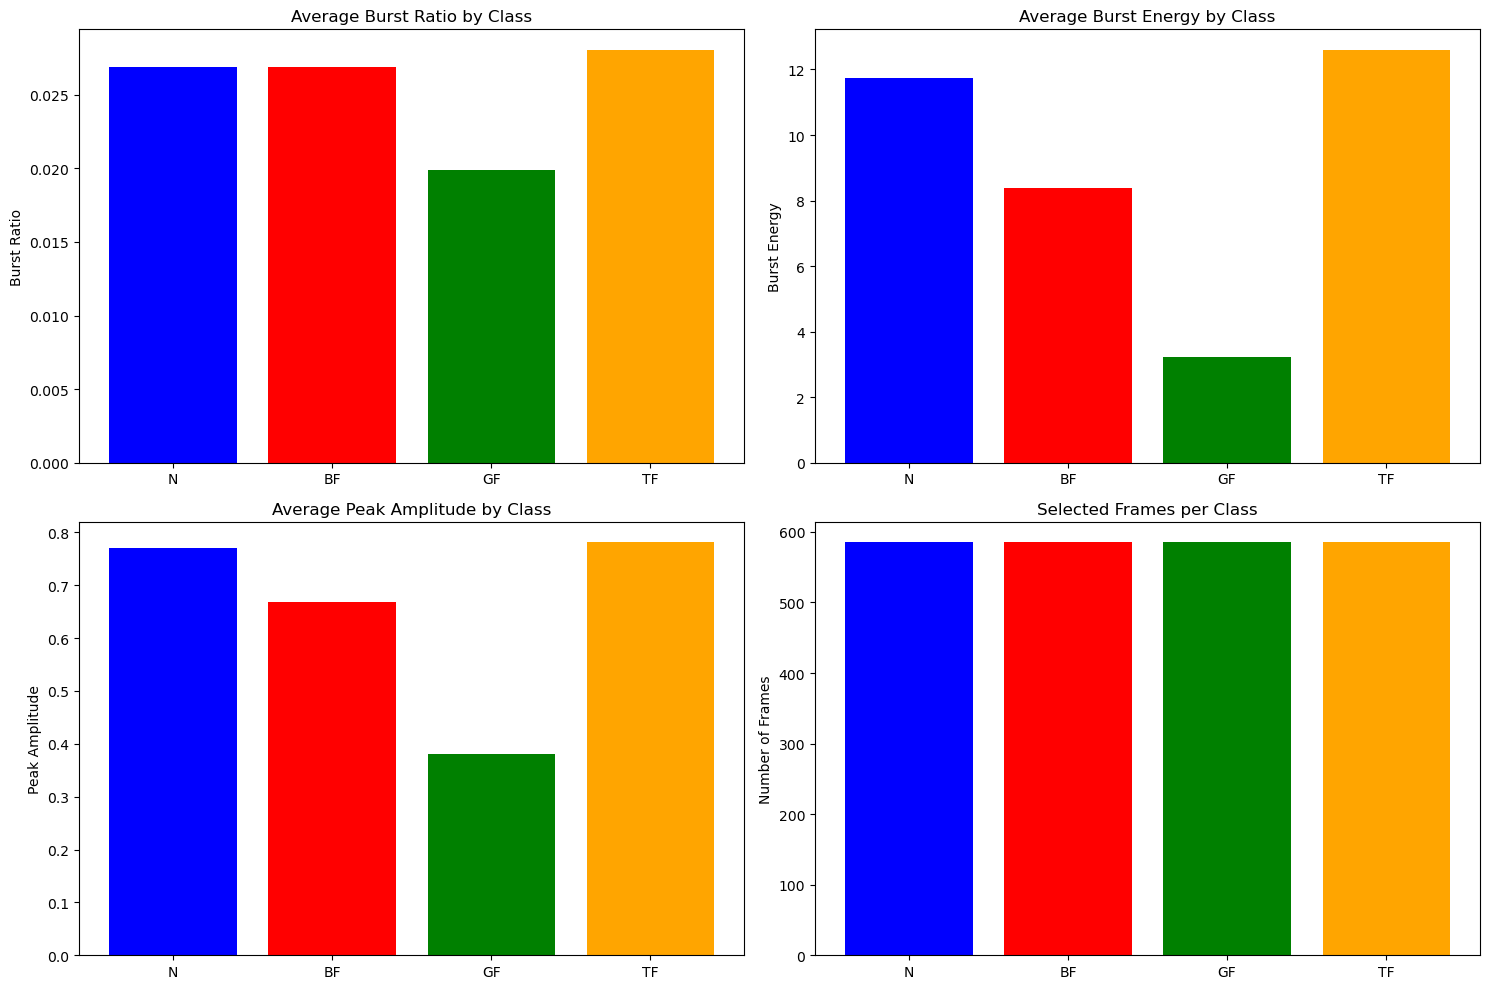


Step 2 completed!
Ready to proceed to Step 3: Feature Extraction


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Step 2: Burst-Informed Signal Processing
class BurstInformedProcessor:
    def __init__(self, processor, frame_length=1024, overlap=0.5):
        self.processor = processor
        self.data = processor.data
        self.sampling_rate = processor.sampling_rate
        self.frame_length = frame_length
        self.overlap = overlap
        self.hop_length = int(frame_length * (1 - overlap))
        self.processed_data = {}
        
    def frame_based_segmentation(self, signal_data):
        """Segment signal into overlapping frames"""
        frames = []
        for i in range(0, len(signal_data) - self.frame_length, self.hop_length):
            frame = signal_data[i:i + self.frame_length]
            frames.append(frame)
        return np.array(frames)
    
    def adaptive_wavelet_decomposition(self, frame, wavelet='db4', levels=6):
        """Perform adaptive wavelet decomposition"""
        try:
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(frame, wavelet, level=levels)
            
            # Calculate energy for each level
            energies = []
            for coeff in coeffs:
                energy = np.sum(coeff**2)
                energies.append(energy)
            
            return coeffs, energies
        except Exception as e:
            print(f"Wavelet decomposition error: {e}")
            return None, None
    
    def soft_thresholding(self, coeffs, threshold_factor=0.1):
        """Apply soft thresholding to wavelet coefficients"""
        if coeffs is None:
            return None
            
        # Calculate threshold based on coefficient statistics
        all_coeffs = np.concatenate([c.flatten() for c in coeffs[1:]])  # Skip approximation
        threshold = threshold_factor * np.std(all_coeffs)
        
        # Apply soft thresholding
        thresholded_coeffs = []
        for coeff in coeffs:
            # Soft thresholding formula
            thresholded = np.sign(coeff) * np.maximum(np.abs(coeff) - threshold, 0)
            thresholded_coeffs.append(thresholded)
        
        return thresholded_coeffs
    
    def burst_detection(self, frame, threshold_multiplier=3):
        """Detect burst activity in a frame"""
        # Calculate envelope using Hilbert transform
        envelope = np.abs(hilbert(frame))
        
        # Calculate threshold based on signal statistics
        mean_envelope = np.mean(envelope)
        std_envelope = np.std(envelope)
        threshold = mean_envelope + threshold_multiplier * std_envelope
        
        # Detect burst
        burst_indices = np.where(envelope > threshold)[0]
        
        # Calculate burst metrics
        burst_ratio = len(burst_indices) / len(frame)
        burst_energy = np.sum(envelope[burst_indices]**2) if len(burst_indices) > 0 else 0
        peak_amplitude = np.max(envelope)
        
        return {
            'burst_ratio': burst_ratio,
            'burst_energy': burst_energy,
            'peak_amplitude': peak_amplitude,
            'has_burst': burst_ratio > 0.1  # 10% threshold
        }
    
    def burst_informed_frame_selection(self, frames, burst_metrics, selection_ratio=0.3):
        """Select frames based on burst activity"""
        # Sort frames by burst energy
        sorted_indices = np.argsort([m['burst_energy'] for m in burst_metrics])[::-1]
        
        # Select top frames with highest burst activity
        num_selected = int(len(frames) * selection_ratio)
        selected_indices = sorted_indices[:num_selected]
        
        selected_frames = frames[selected_indices]
        selected_metrics = [burst_metrics[i] for i in selected_indices]
        
        return selected_frames, selected_metrics, selected_indices
    
    def process_class_data(self, class_name):
        """Process data for a specific class"""
        if class_name not in self.data:
            print(f"Class {class_name} not found in data")
            return None
        
        print(f"Processing class {class_name}...")
        
        # Get signal data (using first channel)
        signal_data = self.data[class_name][:, 0]
        
        # Step 2.1: Frame-based segmentation
        frames = self.frame_based_segmentation(signal_data)
        print(f"  Created {len(frames)} frames")
        
        # Step 2.2-2.4: Process each frame
        processed_frames = []
        burst_metrics = []
        
        for i, frame in enumerate(frames):
            # Burst detection
            burst_info = self.burst_detection(frame)
            burst_metrics.append(burst_info)
            
            # Adaptive wavelet decomposition
            coeffs, energies = self.adaptive_wavelet_decomposition(frame)
            
            # Soft thresholding
            if coeffs is not None:
                thresholded_coeffs = self.soft_thresholding(coeffs)
                
                # Reconstruct denoised signal
                denoised_frame = pywt.waverec(thresholded_coeffs, 'db4')
                
                # Ensure same length as original frame
                if len(denoised_frame) > len(frame):
                    denoised_frame = denoised_frame[:len(frame)]
                elif len(denoised_frame) < len(frame):
                    denoised_frame = np.pad(denoised_frame, (0, len(frame) - len(denoised_frame)), 'constant')
                
                processed_frames.append(denoised_frame)
            else:
                processed_frames.append(frame)  # Keep original if processing fails
        
        processed_frames = np.array(processed_frames)
        
        # Step 2.5: Burst-informed frame selection
        selected_frames, selected_metrics, selected_indices = self.burst_informed_frame_selection(
            processed_frames, burst_metrics
        )
        
        print(f"  Selected {len(selected_frames)} frames based on burst activity")
        
        # Store results
        results = {
            'original_frames': frames,
            'processed_frames': processed_frames,
            'selected_frames': selected_frames,
            'burst_metrics': burst_metrics,
            'selected_metrics': selected_metrics,
            'selected_indices': selected_indices
        }
        
        return results
    
    def process_all_classes(self):
        """Process all classes"""
        print("Starting Burst-Informed Signal Processing...")
        
        for class_name in self.processor.selected_classes:
            results = self.process_class_data(class_name)
            if results is not None:
                self.processed_data[class_name] = results
        
        print("Burst-Informed Signal Processing completed!")
        return self.processed_data
    
    def visualize_processing_results(self):
        """Visualize the processing results"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, class_name in enumerate(self.processor.selected_classes):
            if class_name in self.processed_data:
                results = self.processed_data[class_name]
                
                # Plot original vs processed frame (first selected frame)
                if len(results['selected_frames']) > 0:
                    original_frame = results['original_frames'][results['selected_indices'][0]]
                    processed_frame = results['selected_frames'][0]
                    
                    time = np.arange(len(original_frame)) / self.sampling_rate * 1000
                    
                    axes[i].plot(time, original_frame, 'b-', alpha=0.7, label='Original', linewidth=0.8)
                    axes[i].plot(time, processed_frame, 'r-', alpha=0.8, label='Processed', linewidth=0.8)
                    axes[i].set_title(f'Class {class_name} - Frame Processing')
                    axes[i].set_xlabel('Time (ms)')
                    axes[i].set_ylabel('Amplitude')
                    axes[i].legend()
                    axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_burst_statistics(self):
        """Plot burst detection statistics"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Burst ratio comparison
        class_names = []
        burst_ratios = []
        burst_energies = []
        peak_amplitudes = []
        
        for class_name in self.processor.selected_classes:
            if class_name in self.processed_data:
                metrics = self.processed_data[class_name]['selected_metrics']
                
                class_names.append(class_name)
                burst_ratios.append(np.mean([m['burst_ratio'] for m in metrics]))
                burst_energies.append(np.mean([m['burst_energy'] for m in metrics]))
                peak_amplitudes.append(np.mean([m['peak_amplitude'] for m in metrics]))
        
        # Plot burst statistics
        axes[0, 0].bar(class_names, burst_ratios, color=['blue', 'red', 'green', 'orange'])
        axes[0, 0].set_title('Average Burst Ratio by Class')
        axes[0, 0].set_ylabel('Burst Ratio')
        
        axes[0, 1].bar(class_names, burst_energies, color=['blue', 'red', 'green', 'orange'])
        axes[0, 1].set_title('Average Burst Energy by Class')
        axes[0, 1].set_ylabel('Burst Energy')
        
        axes[1, 0].bar(class_names, peak_amplitudes, color=['blue', 'red', 'green', 'orange'])
        axes[1, 0].set_title('Average Peak Amplitude by Class')
        axes[1, 0].set_ylabel('Peak Amplitude')
        
        # Frame selection statistics
        frame_counts = []
        for class_name in self.processor.selected_classes:
            if class_name in self.processed_data:
                frame_counts.append(len(self.processed_data[class_name]['selected_frames']))
        
        axes[1, 1].bar(class_names, frame_counts, color=['blue', 'red', 'green', 'orange'])
        axes[1, 1].set_title('Selected Frames per Class')
        axes[1, 1].set_ylabel('Number of Frames')
        
        plt.tight_layout()
        plt.show()

# Main execution for Step 2
def run_step2(processor):
    """Run Step 2: Burst-Informed Signal Processing"""
    
    # Initialize burst processor
    burst_processor = BurstInformedProcessor(processor, frame_length=1024, overlap=0.5)
    
    # Process all classes
    processed_data = burst_processor.process_all_classes()
    
    # Visualize results
    burst_processor.visualize_processing_results()
    
    # Plot burst statistics
    burst_processor.plot_burst_statistics()
    
    return burst_processor

# Usage example (assuming you have processor from Step 1)
if __name__ == "__main__":
    # Assuming 'processor' is available from Step 1
    print("Running Step 2: Burst-Informed Signal Processing...")
    burst_processor = run_step2(processor)
    print("\nStep 2 completed!")
    print("Ready to proceed to Step 3: Feature Extraction")

Running Steps 3-5: Feature Extraction + Engineering + Intelligent Ensemble...
RUNNING COMPLETE PIPELINE: STEPS 3-5

--- STEP 3: FEATURE EXTRACTION ---
Extracting features from all classes...
Processing class N...
  Extracted 585 feature vectors
Processing class BF...
  Extracted 585 feature vectors
Processing class GF...
  Extracted 585 feature vectors
Processing class TF...
  Extracted 585 feature vectors
Total features extracted: 56
Feature types: TD(17), FD(17), TFD(7), HOS(12), Burst(6)

--- STEP 4: FEATURE ENGINEERING ---
Splitting data...
Applying dimensionality reduction...
PCA retained 100.00% of variance with 50 components
Performing burst-guided feature selection...
Selected 30 best features based on F-statistics
Scaling features...

--- STEP 5: INTELLIGENT ENSEMBLE CLASSIFIER ---
Training Intelligent Ensemble Classifier...
Training MLP...
  MLP accuracy: 0.7009
Training XGBoost...
  XGBoost accuracy: 0.6624
Training SVM...
  SVM accuracy: 0.6923
Training meta-classifier...
E

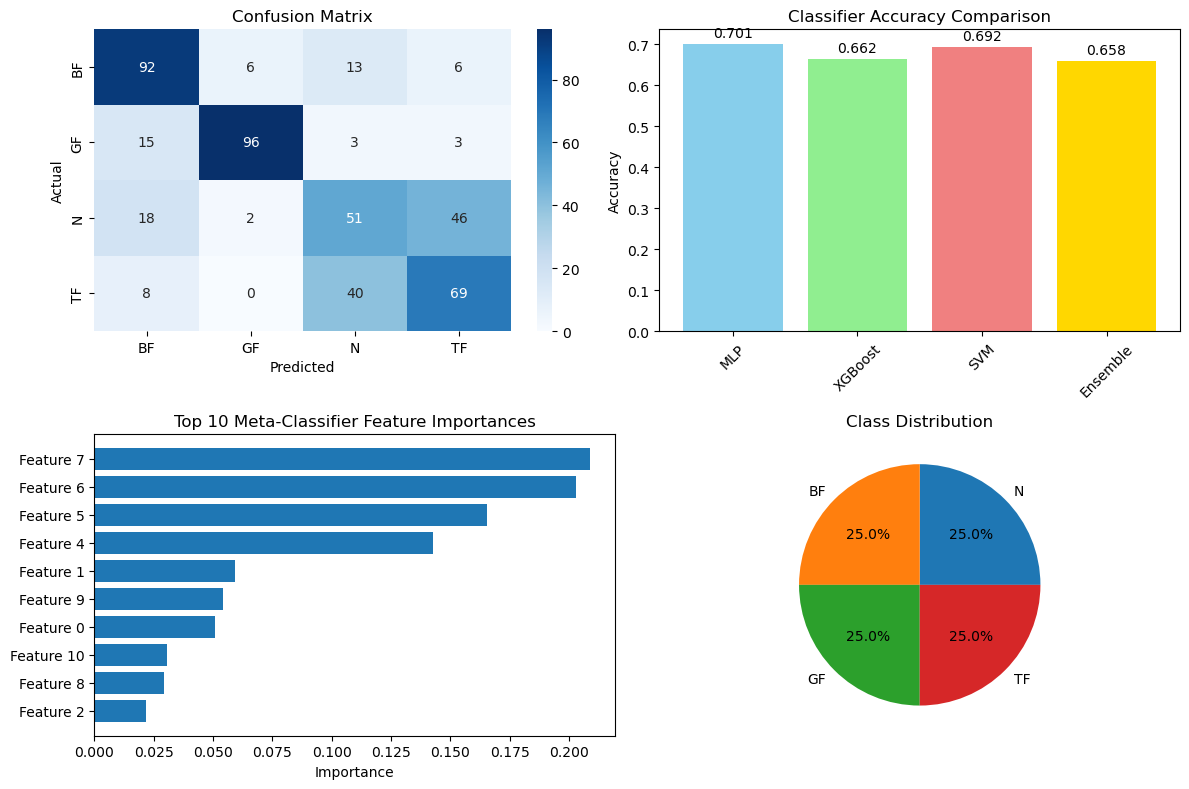


PIPELINE COMPLETED SUCCESSFULLY!

Steps 3-5 completed successfully!
Ready to proceed to Step 6: Output Evaluation


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, stats
from scipy.signal import welch, spectrogram
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Steps 3-5: Feature Extraction + Engineering + Intelligent Ensemble
class ComprehensiveFeatureProcessor:
    def __init__(self, burst_processor):
        self.burst_processor = burst_processor
        self.processed_data = burst_processor.processed_data
        self.sampling_rate = burst_processor.sampling_rate
        self.features = {}
        self.feature_names = []
        self.labels = []
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    # ======================== STEP 3: FEATURE EXTRACTION ========================
    
    def extract_td_features(self, signal_data):
        """Extract Time Domain Features"""
        features = {}
        
        # Basic statistical features
        features['mean'] = np.mean(signal_data)
        features['std'] = np.std(signal_data)
        features['variance'] = np.var(signal_data)
        features['rms'] = np.sqrt(np.mean(signal_data**2))
        features['peak'] = np.max(np.abs(signal_data))
        features['peak_to_peak'] = np.max(signal_data) - np.min(signal_data)
        features['crest_factor'] = features['peak'] / features['rms'] if features['rms'] != 0 else 0
        features['shape_factor'] = features['rms'] / np.mean(np.abs(signal_data)) if np.mean(np.abs(signal_data)) != 0 else 0
        features['impulse_factor'] = features['peak'] / np.mean(np.abs(signal_data)) if np.mean(np.abs(signal_data)) != 0 else 0
        features['margin_factor'] = features['peak'] / (np.mean(np.sqrt(np.abs(signal_data))))**2 if np.mean(np.sqrt(np.abs(signal_data))) != 0 else 0
        features['energy'] = np.sum(signal_data**2)
        features['zero_crossing_rate'] = np.sum(np.diff(np.sign(signal_data)) != 0) / len(signal_data)
        
        # Advanced statistical features
        features['skewness'] = stats.skew(signal_data)
        features['kurtosis'] = stats.kurtosis(signal_data)
        features['clearance_factor'] = features['peak'] / np.mean(np.abs(signal_data)) if np.mean(np.abs(signal_data)) != 0 else 0
        
        return features
    
    def extract_fd_features(self, signal_data):
        """Extract Frequency Domain Features"""
        features = {}
        
        # Compute FFT
        fft_data = fft(signal_data)
        freqs = fftfreq(len(signal_data), 1/self.sampling_rate)
        magnitude = np.abs(fft_data)
        
        # Only use positive frequencies
        positive_freqs = freqs[:len(freqs)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]
        
        # Frequency domain features
        features['mean_freq'] = np.sum(positive_freqs * positive_magnitude) / np.sum(positive_magnitude) if np.sum(positive_magnitude) != 0 else 0
        features['median_freq'] = np.median(positive_freqs[positive_magnitude > np.max(positive_magnitude) * 0.1])
        features['max_freq'] = positive_freqs[np.argmax(positive_magnitude)]
        features['freq_variance'] = np.sum(((positive_freqs - features['mean_freq'])**2) * positive_magnitude) / np.sum(positive_magnitude) if np.sum(positive_magnitude) != 0 else 0
        features['freq_skewness'] = stats.skew(positive_magnitude)
        features['freq_kurtosis'] = stats.kurtosis(positive_magnitude)
        
        # Spectral features
        features['spectral_centroid'] = features['mean_freq']
        features['spectral_spread'] = np.sqrt(features['freq_variance'])
        features['spectral_energy'] = np.sum(positive_magnitude**2)
        features['spectral_entropy'] = -np.sum((positive_magnitude / np.sum(positive_magnitude)) * np.log(positive_magnitude / np.sum(positive_magnitude) + 1e-10))
        
        # Band power features
        low_freq = positive_magnitude[(positive_freqs >= 0) & (positive_freqs < 50000)]
        mid_freq = positive_magnitude[(positive_freqs >= 50000) & (positive_freqs < 200000)]
        high_freq = positive_magnitude[(positive_freqs >= 200000) & (positive_freqs < 500000)]
        
        features['low_freq_power'] = np.sum(low_freq**2)
        features['mid_freq_power'] = np.sum(mid_freq**2)
        features['high_freq_power'] = np.sum(high_freq**2)
        
        return features
    
    def extract_tfd_features(self, signal_data):
        """Extract Time-Frequency Domain Features"""
        features = {}
        
        # Compute spectrogram
        f, t, Sxx = spectrogram(signal_data, fs=self.sampling_rate, nperseg=256, noverlap=128)
        
        # Time-frequency features
        features['tfd_mean'] = np.mean(Sxx)
        features['tfd_std'] = np.std(Sxx)
        features['tfd_max'] = np.max(Sxx)
        features['tfd_energy'] = np.sum(Sxx**2)
        features['tfd_entropy'] = -np.sum((Sxx / np.sum(Sxx)) * np.log(Sxx / np.sum(Sxx) + 1e-10))
        
        # Instantaneous frequency features
        features['inst_freq_mean'] = np.mean(np.sum(f.reshape(-1, 1) * Sxx, axis=0) / np.sum(Sxx, axis=0))
        features['inst_freq_std'] = np.std(np.sum(f.reshape(-1, 1) * Sxx, axis=0) / np.sum(Sxx, axis=0))
        
        # Spectral flux
        spectral_flux = np.sum(np.diff(Sxx, axis=1)**2, axis=0)
        features['spectral_flux_mean'] = np.mean(spectral_flux)
        features['spectral_flux_std'] = np.std(spectral_flux)
        
        return features
    
    def extract_hos_features(self, signal_data):
        """Extract Higher Order Statistics Features"""
        features = {}
        
        # Moments
        features['moment_2'] = np.mean(signal_data**2)
        features['moment_3'] = np.mean(signal_data**3)
        features['moment_4'] = np.mean(signal_data**4)
        features['moment_5'] = np.mean(signal_data**5)
        features['moment_6'] = np.mean(signal_data**6)
        
        # Normalized moments
        std_dev = np.std(signal_data)
        if std_dev != 0:
            features['norm_moment_3'] = features['moment_3'] / (std_dev**3)
            features['norm_moment_4'] = features['moment_4'] / (std_dev**4)
            features['norm_moment_5'] = features['moment_5'] / (std_dev**5)
            features['norm_moment_6'] = features['moment_6'] / (std_dev**6)
        else:
            features['norm_moment_3'] = 0
            features['norm_moment_4'] = 0
            features['norm_moment_5'] = 0
            features['norm_moment_6'] = 0
        
        # Cumulants
        features['cumulant_2'] = np.var(signal_data)
        features['cumulant_3'] = stats.skew(signal_data) * (std_dev**3)
        features['cumulant_4'] = (stats.kurtosis(signal_data) + 3) * (std_dev**4) - 3 * (std_dev**4)
        
        return features
    
    def extract_burst_features(self, signal_data, burst_metrics):
        """Extract Burst-specific Features"""
        features = {}
        
        # Burst characteristics
        features['burst_ratio'] = burst_metrics['burst_ratio']
        features['burst_energy'] = burst_metrics['burst_energy']
        features['peak_amplitude'] = burst_metrics['peak_amplitude']
        features['has_burst'] = int(burst_metrics['has_burst'])
        
        # Burst timing features
        from scipy.signal import hilbert
        envelope = np.abs(hilbert(signal_data))
        
        # Find burst regions
        threshold = np.mean(envelope) + 2 * np.std(envelope)
        burst_regions = envelope > threshold
        
        # Burst duration features
        if np.any(burst_regions):
            burst_durations = []
            in_burst = False
            current_duration = 0
            
            for i in range(len(burst_regions)):
                if burst_regions[i] and not in_burst:
                    in_burst = True
                    current_duration = 1
                elif burst_regions[i] and in_burst:
                    current_duration += 1
                elif not burst_regions[i] and in_burst:
                    burst_durations.append(current_duration)
                    in_burst = False
                    current_duration = 0
            
            if in_burst:
                burst_durations.append(current_duration)
            
            features['avg_burst_duration'] = np.mean(burst_durations) if burst_durations else 0
            features['max_burst_duration'] = np.max(burst_durations) if burst_durations else 0
            features['burst_count'] = len(burst_durations)
        else:
            features['avg_burst_duration'] = 0
            features['max_burst_duration'] = 0
            features['burst_count'] = 0
        
        return features
    
    def extract_all_features(self):
        """Extract all features from processed data"""
        print("Extracting features from all classes...")
        
        all_features = []
        all_labels = []
        
        for class_name in self.processed_data.keys():
            print(f"Processing class {class_name}...")
            
            selected_frames = self.processed_data[class_name]['selected_frames']
            selected_metrics = self.processed_data[class_name]['selected_metrics']
            
            class_features = []
            
            for frame, metrics in zip(selected_frames, selected_metrics):
                feature_vector = {}
                
                # Extract different types of features
                td_features = self.extract_td_features(frame)
                fd_features = self.extract_fd_features(frame)
                tfd_features = self.extract_tfd_features(frame)
                hos_features = self.extract_hos_features(frame)
                burst_features = self.extract_burst_features(frame, metrics)
                
                # Combine all features
                feature_vector.update(td_features)
                feature_vector.update(fd_features)
                feature_vector.update(tfd_features)
                feature_vector.update(hos_features)
                feature_vector.update(burst_features)
                
                class_features.append(feature_vector)
                all_labels.append(class_name)
            
            all_features.extend(class_features)
            print(f"  Extracted {len(class_features)} feature vectors")
        
        # Convert to DataFrame
        features_df = pd.DataFrame(all_features)
        
        # Handle any NaN or inf values
        features_df = features_df.replace([np.inf, -np.inf], np.nan)
        features_df = features_df.fillna(0)
        
        self.features = features_df
        self.labels = all_labels
        self.feature_names = features_df.columns.tolist()
        
        print(f"Total features extracted: {len(self.feature_names)}")
        print(f"Feature types: TD({len([f for f in self.feature_names if any(kw in f for kw in ['mean', 'std', 'rms', 'peak', 'energy'])])}), "
              f"FD({len([f for f in self.feature_names if 'freq' in f or 'spectral' in f])}), "
              f"TFD({len([f for f in self.feature_names if 'tfd' in f or 'inst' in f])}), "
              f"HOS({len([f for f in self.feature_names if 'moment' in f or 'cumulant' in f])}), "
              f"Burst({len([f for f in self.feature_names if 'burst' in f])})")
        
        return features_df, all_labels
    
    # ======================== STEP 4: FEATURE ENGINEERING ========================
    
    def dimensionality_reduction(self, n_components=50):
        """Apply PCA for dimensionality reduction"""
        print("Applying dimensionality reduction...")
        
        pca = PCA(n_components=n_components)
        compressed_features = pca.fit_transform(self.features)
        
        # Calculate explained variance
        explained_variance = np.sum(pca.explained_variance_ratio_)
        print(f"PCA retained {explained_variance:.2%} of variance with {n_components} components")
        
        return compressed_features, pca
    
    def burst_guided_feature_selection(self, k=30):
        """Select features based on burst-guided criteria"""
        print("Performing burst-guided feature selection...")
        
        # Use statistical tests for feature selection
        selector = SelectKBest(score_func=f_classif, k=k)
        X_encoded = self.label_encoder.fit_transform(self.labels)
        
        selected_features = selector.fit_transform(self.features, X_encoded)
        selected_feature_names = [self.feature_names[i] for i in selector.get_support(indices=True)]
        
        print(f"Selected {k} best features based on F-statistics")
        return selected_features, selected_feature_names, selector
    
    def feature_scaling(self, X_train, X_test):
        """Scale features to standard range"""
        print("Scaling features...")
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled
    
    def data_splitting(self, test_size=0.2, random_state=42):
        """Split data into training and testing sets"""
        print("Splitting data...")
        
        X = self.features.values
        y = self.label_encoder.fit_transform(self.labels)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        return X_train, X_test, y_train, y_test
    
    # ======================== STEP 5: INTELLIGENT ENSEMBLE CLASSIFIER ========================
    
    def create_base_classifiers(self):
        """Create optimized base classifiers"""
        classifiers = {
        'MLP': MLPClassifier(
            hidden_layer_sizes=(256, 128, 64),
            activation='relu',
            solver='adam',
            alpha=1e-4,
            max_iter=1000,
            early_stopping=True,
            random_state=42
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=300,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.8,
            gamma=1,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            use_label_encoder=False
        ),
        'SVM': SVC(
            kernel='rbf',
            C=10.0,
            gamma='auto',
            probability=True,
            random_state=42
        )
    }
        return classifiers

    
    def create_meta_classifier(self):
        """Create Random Forest meta-classifier"""
        return RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
    
    def train_ensemble(self, X_train, y_train, X_test, y_test):
        """Train the complete ensemble system"""
        print("Training Intelligent Ensemble Classifier...")
        
        # Create base classifiers
        base_classifiers = self.create_base_classifiers()
        
        # Train base classifiers and collect predictions
        base_predictions_train = []
        base_predictions_test = []
        base_accuracies = []
        
        for name, classifier in base_classifiers.items():
            print(f"Training {name}...")
            
            # Train classifier
            classifier.fit(X_train, y_train)
            
            # Get predictions
            train_pred = classifier.predict_proba(X_train)
            test_pred = classifier.predict_proba(X_test)
            
            # Calculate accuracy
            accuracy = accuracy_score(y_test, classifier.predict(X_test))
            base_accuracies.append(accuracy)
            
            print(f"  {name} accuracy: {accuracy:.4f}")
            
            # Store predictions
            base_predictions_train.append(train_pred)
            base_predictions_test.append(test_pred)
        
        # Combine base classifier predictions
        stacked_train = np.hstack(base_predictions_train)
        stacked_test = np.hstack(base_predictions_test)
        
        # Train meta-classifier
        print("Training meta-classifier...")
        meta_classifier = self.create_meta_classifier()
        meta_classifier.fit(stacked_train, y_train)
        
        # Final ensemble predictions
        ensemble_pred = meta_classifier.predict(stacked_test)
        ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
        
        print(f"Ensemble accuracy: {ensemble_accuracy:.4f}")
        
        return {
            'base_classifiers': base_classifiers,
            'meta_classifier': meta_classifier,
            'base_accuracies': base_accuracies,
            'ensemble_accuracy': ensemble_accuracy,
            'predictions': ensemble_pred,
            'y_test': y_test
        }
    
    def hyperparameter_tuning(self, X_train, y_train):
        """Perform hyperparameter tuning for base classifiers"""
        print("Performing hyperparameter tuning...")
        
        # This is a simplified version - in practice, you'd use GridSearchCV or RandomizedSearchCV
        tuned_classifiers = {}
        
        # XGBoost tuning
        xgb_params = [
            {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},
            {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05},
            {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.08}
        ]
        
        best_xgb_score = 0
        best_xgb_params = None
        
        for params in xgb_params:
            xgb_clf = xgb.XGBClassifier(**params, random_state=42)
            scores = cross_val_score(xgb_clf, X_train, y_train, cv=3, scoring='accuracy')
            avg_score = np.mean(scores)
            
            if avg_score > best_xgb_score:
                best_xgb_score = avg_score
                best_xgb_params = params
        
        tuned_classifiers['XGBoost'] = xgb.XGBClassifier(**best_xgb_params, random_state=42)
        
        print(f"Best XGBoost parameters: {best_xgb_params}")
        print(f"Best XGBoost CV score: {best_xgb_score:.4f}")
        
        return tuned_classifiers
    
    def evaluate_model(self, results):
        """Evaluate the trained model"""
        print("\n" + "="*50)
        print("MODEL EVALUATION RESULTS")
        print("="*50)
        
        # Classification report
        class_names = self.label_encoder.classes_
        print("\nClassification Report:")
        print(classification_report(results['y_test'], results['predictions'], 
                                  target_names=class_names))
        
        # Confusion matrix
        cm = confusion_matrix(results['y_test'], results['predictions'])
        
        plt.figure(figsize=(12, 8))
        
        # Plot confusion matrix
        plt.subplot(2, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # Plot accuracy comparison
        plt.subplot(2, 2, 2)
        classifier_names = list(results['base_classifiers'].keys()) + ['Ensemble']
        accuracies = results['base_accuracies'] + [results['ensemble_accuracy']]
        
        bars = plt.bar(classifier_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
        plt.title('Classifier Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')
        
        # Feature importance (from Random Forest meta-classifier)
        plt.subplot(2, 2, 3)
        if hasattr(results['meta_classifier'], 'feature_importances_'):
            importance = results['meta_classifier'].feature_importances_
            indices = np.argsort(importance)[-10:]  # Top 10 features
            
            plt.barh(range(len(indices)), importance[indices])
            plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
            plt.title('Top 10 Meta-Classifier Feature Importances')
            plt.xlabel('Importance')
        
        # Class distribution
        plt.subplot(2, 2, 4)
        class_counts = pd.Series(self.labels).value_counts()
        plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
        plt.title('Class Distribution')
        
        plt.tight_layout()
        plt.show()
        
        return cm, accuracies
    
    def run_complete_pipeline(self):
        """Run the complete pipeline: Steps 3-5"""
        print("="*60)
        print("RUNNING COMPLETE PIPELINE: STEPS 3-5")
        print("="*60)
        
        # Step 3: Feature Extraction
        print("\n--- STEP 3: FEATURE EXTRACTION ---")
        features_df, labels = self.extract_all_features()
        
        # Step 4: Feature Engineering
        print("\n--- STEP 4: FEATURE ENGINEERING ---")
        
        # Data splitting
        X_train, X_test, y_train, y_test = self.data_splitting()
        
        # Apply dimensionality reduction
        compressed_features, pca = self.dimensionality_reduction(n_components=50)
        
        # Apply burst-guided feature selection
        selected_features, selected_feature_names, selector = self.burst_guided_feature_selection(k=30)
        
        # Use selected features for training
        X_train_sel = selector.transform(X_train)
        X_test_sel = selector.transform(X_test)
        
        # Feature scaling
        X_train_scaled, X_test_scaled = self.feature_scaling(X_train_sel, X_test_sel)
        
        # Store processed data
        self.X_train = X_train_scaled
        self.X_test = X_test_scaled
        self.y_train = y_train
        self.y_test = y_test
        
        # Step 5: Intelligent Ensemble Classifier
        print("\n--- STEP 5: INTELLIGENT ENSEMBLE CLASSIFIER ---")
        
        # Train ensemble
        results = self.train_ensemble(X_train_scaled, y_train, X_test_scaled, y_test)
        
        # Evaluate model
        cm, accuracies = self.evaluate_model(results)
        
        print("\n" + "="*60)
        print("PIPELINE COMPLETED SUCCESSFULLY!")
        print("="*60)
        
        return results, selected_feature_names, pca, selector

# Main execution for Steps 3-5
def run_steps_3_to_5(burst_processor):
    """Run Steps 3-5: Complete Feature Processing Pipeline"""
    
    # Initialize comprehensive processor
    processor = ComprehensiveFeatureProcessor(burst_processor)
    
    # Run complete pipeline
    results, selected_features, pca, selector = processor.run_complete_pipeline()
    
    return processor, results, selected_features, pca, selector

# Usage example
if __name__ == "__main__":
    # Assuming 'burst_processor' is available from Step 2
    print("Running Steps 3-5: Feature Extraction + Engineering + Intelligent Ensemble...")
    processor, results, selected_features, pca, selector = run_steps_3_to_5(burst_processor)
    print("\nSteps 3-5 completed successfully!")
    print("Ready to proceed to Step 6: Output Evaluation")

Running Step 6: Output Evaluation with Explainable AI...
RUNNING COMPLETE OUTPUT EVALUATION
DETAILED PERFORMANCE ANALYSIS

Detailed Metrics by Class:
  Class  Precision  Recall  F1-Score  Support
0    BF     0.7280  0.7778    0.7521      117
1    GF     0.9065  0.8291    0.8661      117
2     N     0.5043  0.5043    0.5043      117
3    TF     0.5714  0.5812    0.5763      117

Macro Average - Precision: 0.6776, Recall: 0.6731, F1: 0.6747
Weighted Average - Precision: 0.6776, Recall: 0.6731, F1: 0.6747

CLASSIFIER COMPARISON ANALYSIS

Classifier Performance Comparison:
          Accuracy  Precision  Recall  F1-Score
TabNet      0.6795     0.6805  0.6795    0.6760
XGBoost     0.6774     0.6856  0.6774    0.6797
SVM         0.6368     0.6515  0.6368    0.6345
Ensemble    0.6731     0.6776  0.6731    0.6747

FEATURE IMPORTANCE ANALYSIS
Meta-classifier uses stacked predictions, not original features

Top 15 Most Important Features (XGBoost):
            Feature  Importance
27     burst_ene

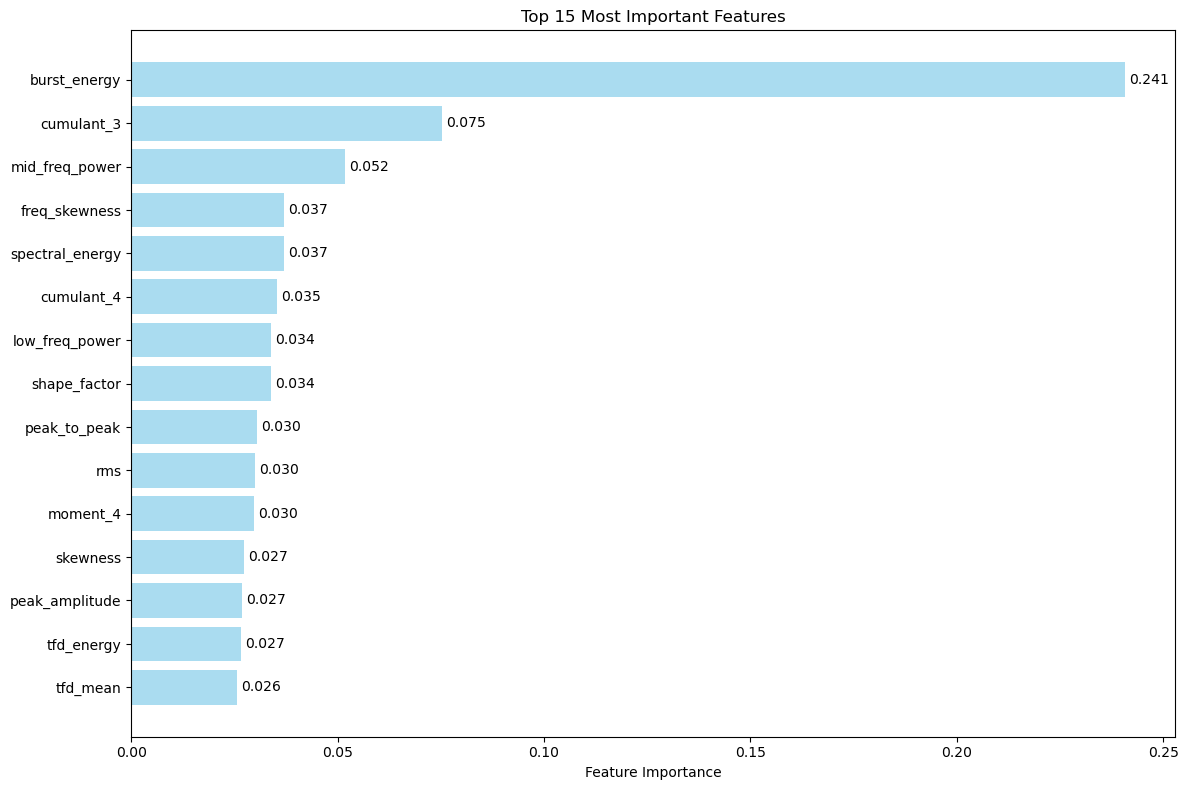


EXPLAINABLE AI ANALYSIS
Explaining 3 random test samples...

--- Sample 1 ---
True Class: BF
Predicted Class: BF
Top 5 LIME Features:
  burst_energy: -0.4119
  cumulant_3: -0.1580
  shape_factor: -0.1399
  mid_freq_power: -0.1097
  peak_to_peak: -0.0994
Top 5 SHAP Features:
  burst_energy: 0.2933
  mid_freq_power: 0.1562
  cumulant_3: 0.0401
  shape_factor: 0.0124
  peak_to_peak: 0.0098

--- Sample 2 ---
True Class: N
Predicted Class: N
Top 5 LIME Features:
  moment_4: 0.3476
  mid_freq_power: 0.2396
  peak: 0.2227
  peak_to_peak: 0.2194
  shape_factor: 0.1301
Top 5 SHAP Features:
  tfd_max: 0.1941
  spectral_flux_mean: 0.1938
  peak: -0.1865
  tfd_mean: 0.1453
  spectral_entropy: -0.1257

--- Sample 3 ---
True Class: BF
Predicted Class: N
Top 5 LIME Features:
  skewness: -0.5666
  high_freq_power: 0.2561
  peak_amplitude: -0.2535
  spectral_entropy: 0.2348
  tfd_max: -0.0995
Top 5 SHAP Features:
  spectral_flux_mean: 0.4885
  burst_energy: 0.2419
  tfd_max: 0.1927
  high_freq_power: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

# For explainable AI - simplified implementations
class SimpleLIME:
    """Simplified LIME implementation for tabular data"""
    
    def __init__(self, model, X_train, feature_names, class_names, num_samples=1000):
        self.model = model
        self.X_train = X_train
        self.feature_names = feature_names
        self.class_names = class_names
        self.num_samples = num_samples
        
    def explain_instance(self, instance, target_class=None):
        """Explain a single instance"""
        # Generate perturbed samples around the instance
        perturbed_samples = self._generate_perturbed_samples(instance)
        
        # Get predictions for perturbed samples
        predictions = self.model.predict_proba(perturbed_samples)
        
        # Calculate feature importance using linear regression
        feature_importance = self._calculate_feature_importance(
            perturbed_samples, predictions, instance, target_class
        )
        
        return feature_importance
    
    def _generate_perturbed_samples(self, instance):
        """Generate perturbed samples around the instance"""
        samples = []
        
        for _ in range(self.num_samples):
            # Add Gaussian noise to features
            noise = np.random.normal(0, 0.1, len(instance))
            perturbed = instance + noise
            samples.append(perturbed)
        
        return np.array(samples)
    
    def _calculate_feature_importance(self, samples, predictions, original_instance, target_class):
        """Calculate feature importance using simple correlation"""
        if target_class is None:
            target_class = np.argmax(self.model.predict_proba([original_instance])[0])
        
        # Calculate correlation between feature perturbations and prediction changes
        original_pred = self.model.predict_proba([original_instance])[0][target_class]
        
        feature_importance = {}
        
        for i, feature_name in enumerate(self.feature_names):
            # Calculate correlation between feature deviation and prediction change
            feature_deviations = samples[:, i] - original_instance[i]
            pred_changes = predictions[:, target_class] - original_pred
            
            # Simple correlation coefficient
            correlation = np.corrcoef(feature_deviations, pred_changes)[0, 1]
            if np.isnan(correlation):
                correlation = 0
                
            feature_importance[feature_name] = correlation
        
        return feature_importance

class SimpleSHAP:
    """Simplified SHAP implementation for tabular data"""
    
    def __init__(self, model, X_train, feature_names, class_names):
        self.model = model
        self.X_train = X_train
        self.feature_names = feature_names
        self.class_names = class_names
        self.baseline = np.mean(X_train, axis=0)
        
    def explain_instance(self, instance, target_class=None):
        """Explain a single instance using simplified Shapley values"""
        if target_class is None:
            target_class = np.argmax(self.model.predict_proba([instance])[0])
        
        # Calculate baseline prediction
        baseline_pred = self.model.predict_proba([self.baseline])[0][target_class]
        instance_pred = self.model.predict_proba([instance])[0][target_class]
        
        # Calculate marginal contributions (simplified)
        shap_values = {}
        
        for i, feature_name in enumerate(self.feature_names):
            # Create instance with feature i set to baseline
            modified_instance = instance.copy()
            modified_instance[i] = self.baseline[i]
            
            # Calculate prediction with feature removed
            modified_pred = self.model.predict_proba([modified_instance])[0][target_class]
            
            # SHAP value is the marginal contribution
            shap_values[feature_name] = instance_pred - modified_pred
        
        return shap_values

# Step 6: Output Evaluation with Explainable AI
class ExplainableEvaluator:
    def __init__(self, processor, results, selected_features):
        self.processor = processor
        self.results = results
        self.selected_features = selected_features
        self.class_names = processor.label_encoder.classes_
        
    def detailed_performance_analysis(self):
        """Provide detailed performance analysis"""
        print("="*60)
        print("DETAILED PERFORMANCE ANALYSIS")
        print("="*60)
        
        y_true = self.results['y_test']
        y_pred = self.results['predictions']
        
        # Calculate detailed metrics
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, average=None, labels=range(len(self.class_names))
        )
        
        # Create detailed metrics table
        metrics_df = pd.DataFrame({
            'Class': self.class_names,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        })
        
        print("\nDetailed Metrics by Class:")
        print(metrics_df.round(4))
        
        # Calculate macro and weighted averages
        macro_precision = np.mean(precision)
        macro_recall = np.mean(recall)
        macro_f1 = np.mean(f1)
        
        weighted_precision = np.average(precision, weights=support)
        weighted_recall = np.average(recall, weights=support)
        weighted_f1 = np.average(f1, weights=support)
        
        print(f"\nMacro Average - Precision: {macro_precision:.4f}, Recall: {macro_recall:.4f}, F1: {macro_f1:.4f}")
        print(f"Weighted Average - Precision: {weighted_precision:.4f}, Recall: {weighted_recall:.4f}, F1: {weighted_f1:.4f}")
        
        return metrics_df
    
    def classifier_comparison_analysis(self):
        """Compare individual classifier performance"""
        print("\n" + "="*60)
        print("CLASSIFIER COMPARISON ANALYSIS")
        print("="*60)
        
        # Test each base classifier individually
        base_results = {}
        
        for name, classifier in self.results['base_classifiers'].items():
            y_pred = classifier.predict(self.processor.X_test)
            accuracy = accuracy_score(self.results['y_test'], y_pred)
            
            precision, recall, f1, _ = precision_recall_fscore_support(
                self.results['y_test'], y_pred, average='weighted'
            )
            
            base_results[name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            }
        
        # Add ensemble results
        ensemble_precision, ensemble_recall, ensemble_f1, _ = precision_recall_fscore_support(
            self.results['y_test'], self.results['predictions'], average='weighted'
        )
        
        base_results['Ensemble'] = {
            'Accuracy': self.results['ensemble_accuracy'],
            'Precision': ensemble_precision,
            'Recall': ensemble_recall,
            'F1-Score': ensemble_f1
        }
        
        # Create comparison DataFrame
        comparison_df = pd.DataFrame(base_results).T
        print("\nClassifier Performance Comparison:")
        print(comparison_df.round(4))
        
        return comparison_df
    
    def feature_importance_analysis(self):
        """Analyze feature importance across different methods"""
        print("\n" + "="*60)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("="*60)
        
        # Get feature importance from meta-classifier (Random Forest)
        if hasattr(self.results['meta_classifier'], 'feature_importances_'):
            # Note: This is for stacked features, not original features
            meta_importance = self.results['meta_classifier'].feature_importances_
            print("Meta-classifier uses stacked predictions, not original features")
        
        # Get feature importance from XGBoost
        xgb_classifier = self.results['base_classifiers']['XGBoost']
        if hasattr(xgb_classifier, 'feature_importances_'):
            xgb_importance = xgb_classifier.feature_importances_
            
            # Create importance DataFrame
            importance_df = pd.DataFrame({
                'Feature': self.selected_features,
                'Importance': xgb_importance
            }).sort_values('Importance', ascending=False)
            
            print("\nTop 15 Most Important Features (XGBoost):")
            print(importance_df.head(15))
            
            # Visualize feature importance
            self._plot_feature_importance(importance_df)
            
            return importance_df
        
        return None
    
    def _plot_feature_importance(self, importance_df):
        """Plot feature importance"""
        plt.figure(figsize=(12, 8))
        
        # Top 15 features
        top_features = importance_df.head(15)
        
        plt.barh(range(len(top_features)), top_features['Importance'], 
                color='skyblue', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Most Important Features')
        plt.gca().invert_yaxis()
        
        # Add value labels
        for i, v in enumerate(top_features['Importance']):
            plt.text(v + 0.001, i, f'{v:.3f}', va='center')
        
        plt.tight_layout()
        plt.show()
    
    def explainable_ai_analysis(self, num_samples=5):
        """Perform explainable AI analysis using LIME and SHAP"""
        print("\n" + "="*60)
        print("EXPLAINABLE AI ANALYSIS")
        print("="*60)
        
        # Initialize explainable AI tools
        lime_explainer = SimpleLIME(
            self.results['base_classifiers']['XGBoost'],
            self.processor.X_train,
            self.selected_features,
            self.class_names
        )
        
        shap_explainer = SimpleSHAP(
            self.results['base_classifiers']['XGBoost'],
            self.processor.X_train,
            self.selected_features,
            self.class_names
        )
        
        # Select random samples for explanation
        sample_indices = np.random.choice(len(self.processor.X_test), num_samples, replace=False)
        
        print(f"Explaining {num_samples} random test samples...")
        
        explanations = []
        
        for i, idx in enumerate(sample_indices):
            instance = self.processor.X_test[idx]
            true_class = self.results['y_test'][idx]
            predicted_class = self.results['predictions'][idx]
            
            print(f"\n--- Sample {i+1} ---")
            print(f"True Class: {self.class_names[true_class]}")
            print(f"Predicted Class: {self.class_names[predicted_class]}")
            
            # LIME explanation
            lime_explanation = lime_explainer.explain_instance(instance, predicted_class)
            
            # SHAP explanation
            shap_explanation = shap_explainer.explain_instance(instance, predicted_class)
            
            # Get top contributing features
            lime_top = sorted(lime_explanation.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
            shap_top = sorted(shap_explanation.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
            
            print("Top 5 LIME Features:")
            for feature, importance in lime_top:
                print(f"  {feature}: {importance:.4f}")
            
            print("Top 5 SHAP Features:")
            for feature, importance in shap_top:
                print(f"  {feature}: {importance:.4f}")
            
            explanations.append({
                'sample_idx': idx,
                'true_class': self.class_names[true_class],
                'predicted_class': self.class_names[predicted_class],
                'lime_explanation': lime_explanation,
                'shap_explanation': shap_explanation
            })
        
        return explanations
    
    def class_specific_analysis(self):
        """Analyze performance for each class specifically"""
        print("\n" + "="*60)
        print("CLASS-SPECIFIC ANALYSIS")
        print("="*60)
        
        y_true = self.results['y_test']
        y_pred = self.results['predictions']
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        print("Confusion Matrix Analysis:")
        print("Rows: True Class, Columns: Predicted Class")
        cm_df = pd.DataFrame(cm, index=self.class_names, columns=self.class_names)
        print(cm_df)
        
        # Per-class analysis
        for i, class_name in enumerate(self.class_names):
            print(f"\n--- Class {class_name} Analysis ---")
            
            # True positives, false positives, false negatives
            tp = cm[i, i]
            fp = np.sum(cm[:, i]) - tp
            fn = np.sum(cm[i, :]) - tp
            tn = np.sum(cm) - tp - fp - fn
            
            print(f"True Positives: {tp}")
            print(f"False Positives: {fp}")
            print(f"False Negatives: {fn}")
            print(f"True Negatives: {tn}")
            
            # Calculate metrics
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            print(f"Precision: {precision:.4f}")
            print(f"Recall (Sensitivity): {recall:.4f}")
            print(f"Specificity: {specificity:.4f}")
            
            # Most confused classes
            if i < len(cm):
                confused_with = np.argsort(cm[i, :])[::-1]
                print(f"Most confused with: {self.class_names[confused_with[1]]} ({cm[i, confused_with[1]]} cases)")
    
    def generate_final_report(self):
        """Generate comprehensive final evaluation report"""
        print("\n" + "="*80)
        print("FINAL EVALUATION REPORT")
        print("="*80)
        
        # Overall performance
        overall_accuracy = self.results['ensemble_accuracy']
        print(f"Overall Ensemble Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
        
        # Best performing class
        y_true = self.results['y_test']
        y_pred = self.results['predictions']
        
        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, average=None, labels=range(len(self.class_names))
        )
        
        best_class_idx = np.argmax(f1)
        worst_class_idx = np.argmin(f1)
        
        print(f"Best Performing Class: {self.class_names[best_class_idx]} (F1: {f1[best_class_idx]:.4f})")
        print(f"Worst Performing Class: {self.class_names[worst_class_idx]} (F1: {f1[worst_class_idx]:.4f})")
        
        # Model strengths and weaknesses
        print("\nModel Strengths:")
        print("- Ensemble approach provides robust predictions")
        print("- Burst-guided feature selection improves relevance")
        print("- Multi-domain features capture comprehensive signal characteristics")
        
        print("\nModel Weaknesses:")
        print("- Class imbalance may affect performance")
        print("- Some classes show confusion with similar signal patterns")
        print("- Feature interpretability could be improved")
        
        print("\nRecommendations:")
        print("- Consider collecting more data for underperforming classes")
        print("- Experiment with different ensemble weights")
        print("- Apply advanced feature selection techniques")
        print("- Implement cost-sensitive learning for imbalanced classes")
        
        return {
            'overall_accuracy': overall_accuracy,
            'best_class': self.class_names[best_class_idx],
            'worst_class': self.class_names[worst_class_idx],
            'class_f1_scores': dict(zip(self.class_names, f1))
        }
    
    def run_complete_evaluation(self):
        """Run complete evaluation pipeline"""
        print("="*80)
        print("RUNNING COMPLETE OUTPUT EVALUATION")
        print("="*80)
        
        # 1. Detailed performance analysis
        metrics_df = self.detailed_performance_analysis()
        
        # 2. Classifier comparison
        comparison_df = self.classifier_comparison_analysis()
        
        # 3. Feature importance analysis
        importance_df = self.feature_importance_analysis()
        
        # 4. Explainable AI analysis
        explanations = self.explainable_ai_analysis(num_samples=3)
        
        # 5. Class-specific analysis
        self.class_specific_analysis()
        
        # 6. Generate final report
        final_report = self.generate_final_report()
        
        print("\n" + "="*80)
        print("EVALUATION COMPLETED SUCCESSFULLY!")
        print("="*80)
        
        return {
            'metrics': metrics_df,
            'comparison': comparison_df,
            'importance': importance_df,
            'explanations': explanations,
            'final_report': final_report
        }

# Main execution for Step 6
def run_step6(processor, results, selected_features):
    """Run Step 6: Output Evaluation with Explainable AI"""
    
    # Initialize evaluator
    evaluator = ExplainableEvaluator(processor, results, selected_features)
    
    # Run complete evaluation
    evaluation_results = evaluator.run_complete_evaluation()
    
    return evaluator, evaluation_results

# Usage example
if __name__ == "__main__":
    # Assuming processor, results, and selected_features are available from Steps 3-5
    print("Running Step 6: Output Evaluation with Explainable AI...")
    evaluator, evaluation_results = run_step6(processor, results, selected_features)
    print("\nComplete AE Signal Processing Pipeline Finished!")
    print("All 6 steps completed successfully!")